# Notebook Summary
In this notebook I test various basic models on the data

In [1]:
import autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import Classes

In [2]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Pickle in Data

In [5]:
# Pickle in factorized data

path = r"C:\Users\Andrew\Documents\Metis\TikTok_Hit_Predictor\Pickle\supervised_factorized.pkl"

df = pickle.load(open(path,'rb'))
df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,spotify_artists,success
0,0.880,0.501,2.0,-6.774,1.0,0.062,0.0494,0.0695,0.4360,0.459,120.038,2020.0,0,1.0
1,0.935,0.454,1.0,-7.509,1.0,0.375,0.0194,0.0000,0.0824,0.357,133.073,2018.0,1,1.0


# 1) Initial Logistic Regression

In [6]:
# Seperate features from label

X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','year','spotify_artists']]

y = df['success']

In [7]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [8]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# run initial logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

In [11]:
Classes.train_scores(lr,X_train, y_train)

Train Scores
Accuracy score:  91.51%


In [12]:
Classes.test_scores(y_test,y_predict)

Test Scores
Score:  90.88%
F1 score:  63.35%
Precision:  63.02%,  Test Recall:  63.68%


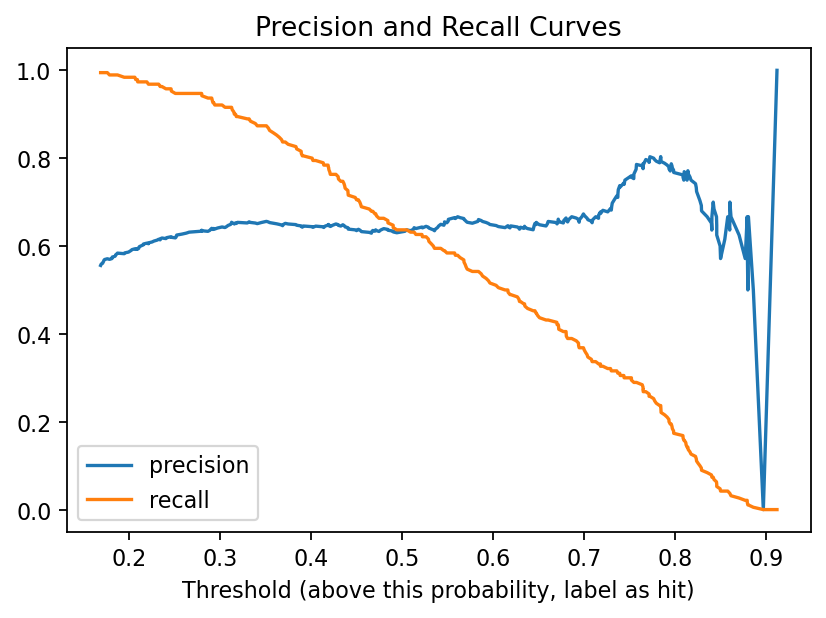

In [14]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

## These initial results are okay - let's try oversampling 

In [15]:
# Seperate features from label

X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','year','spotify_artists']]

y = df['success']

In [16]:
#Split data into 2: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
ada = ADASYN(random_state=42)

In [18]:
# Oversample training data
X_adasyn_tr, y_adasyn_tr = ada.fit_resample(X_train,y_train)

In [19]:
Counter(y_adasyn_tr)

Counter({0.0: 5382, 1.0: 5418})

In [20]:
# Scale features 
scaler = StandardScaler()
X_adasyn_tr = scaler.fit_transform(X_adasyn_tr)
X_test = scaler.transform(X_test)

In [21]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_adasyn_tr, y_adasyn_tr)
y_predict = lr.predict(X_test)

In [22]:
Classes.train_scores(lr,X_train, y_train)

Train Scores
Accuracy score:  89.69%


In [23]:
Classes.test_scores(y_test,y_predict)

Test Scores
Score:  91.07%
F1 score:  73.29%
Precision:  58.20%,  Test Recall:  98.95%


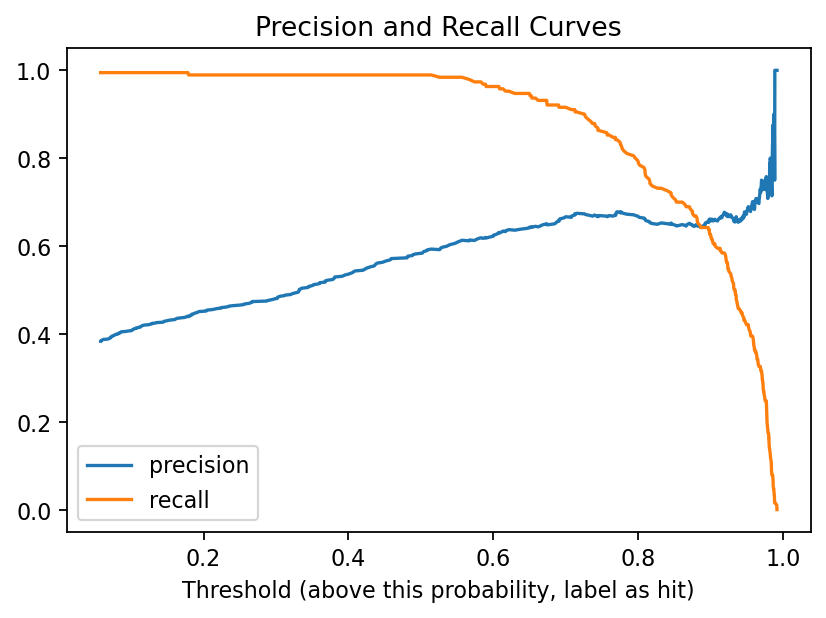

In [24]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

# Appling PCA & Oversampling

In [60]:
# Seperate features from label

X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','year','spotify_artists']]

y = df['success']

In [61]:
# Oversample

#Split data into 2: 80% train,20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

ada = ADASYN(random_state=42)

# Oversample training data
X_adasyn_tr, y_adasyn_tr = ada.fit_resample(X_train,y_train)

In [62]:
# Scale features 
scaler = StandardScaler()
X_adasyn_tr = scaler.fit_transform(X_adasyn_tr)
X_test = scaler.transform(X_test)

In [63]:
# Determining number of PCA components for 95% of variation
pca = PCA()
X_pca = pca.fit_transform(X_adasyn_tr)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1

In [64]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
# set the tolerance to a large value to make the example faster
lr = LogisticRegression()
pca = PCA(n_components=n_to_reach_95)

In [65]:
# fit logistic regression and pca
X_pca_train = pca.fit_transform(X_adasyn_tr)
lr.fit(X_pca_train, y_adasyn_tr) # fit to train

LogisticRegression()

In [66]:
# transform val data with pca

X_test_pca = pca.transform(X_test)

In [67]:
# Test regression
y_predict = lr.predict(X_test_pca)

In [68]:
Classes.train_scores(lr,X_pca_train, y_adasyn_tr)

Train Scores
Accuracy score:  90.93%


In [69]:
Classes.test_scores(y_test,y_predict)

Test Scores
Score:  87.43%
F1 score:  65.84%
Precision:  49.60%,  Test Recall:  97.89%


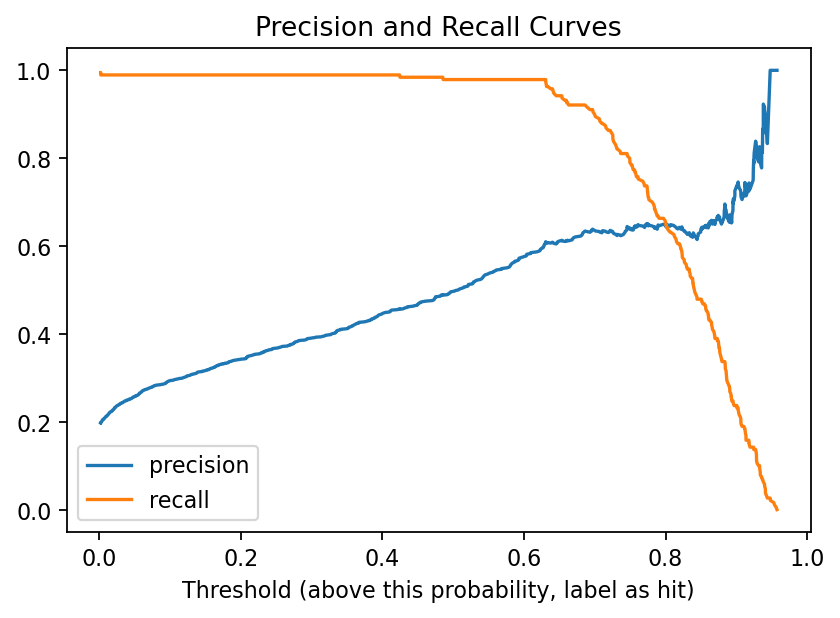

In [70]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test_pca)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

PCA doesn't improve score